## Learning G-equivariant Representation

In this question, we will learn a G-equivariant MLP Auto-Encoder.

- Task: Simply reconstruct the input MNIST handwritten digit with your MLP.

- Training data
    - Consider the MNIST dataset of handwritten digits:
<center><img src="example_image.png" width=300px /></center>
    - The above dataset contains mostly upright digits that we will give as input to our MLP training.

- Now consider the following out-of-distribution test data
    - Consider the transformation group $G_\text{rot} \equiv \{T^{(\theta)}\}_{k\in \{0^\circ,90^\circ,180^\circ,270^\circ\}}$, which rotates the image by $\theta$ degrees, where $T^{(0)}$ is the identity transformation.
    - The input to the transformation group is ${\bf x}$, the **vectorized** image, and we aim to reconstruct the input image using our Auto-Encoder model
    - The Kronecker product in pytorch can be invoked as ```torch.kron```

- Task: Training a G-equivariant MLP auto-encoder over the standard (upright) MNIST data.
    - That is, if your MLP receives a rotated MLP in the test data, it will try to output the same rotated image

A standard MLP trained on mostly upright images, will be confused when we give out-of-distribution (rotated) data. For instance output of a simple Auto-Encoder model that it does not work on rotated input:
<center><img src="example-ae-output.png" width=300px /></center>

- We can observe that, for a standard MLP, the reconstructed output is a much worse for a rotated input than the original MNIST input. 

# Your Task:
**In what follows, you are required to fill in the code for constructing a G-equivairant Auto-Encoder model that is able to correct reconstruct the out-of-distribution (rotated) MNIST images.**

We first review some concepts from the class.
### G-equivariant Representations

- Consider an input in $\mathbb{R}^m$.
- And the output in $\mathbb{R}^k$.
- Let ${\bf W} \in \mathbb{R}^{k \times m}$ be the neuron parameters
- Equivariance requires that transforming the input is the same as transforming the output: $$
{\bf x} \in \mathbb{R}^m, \forall g \in G , \quad \rho_2(g) {\bf W} {\bf x} =  {\bf W} \rho_1(g) {\bf x},
$$ where $\rho_1:G \to \mathbb{R}^{\sqrt{m} \times \sqrt{m}}$ and $\rho_2:G \to \mathbb{R}^{\sqrt{k} \times \sqrt{k}}$. (Thus we require $k$ and $m$ to be perfect square numbers.)
- Since the above is true for all ${\bf x}$, then  $$\rho_2(g) {\bf W} \rho_1(g)^{-1} =  {\bf W},$$
or equivalently  $$\forall g \in G, \qquad \rho_2(g) \otimes \rho_1(g^{-1})^T \text{vec}({\bf W})  =  \text{vec}({\bf W}),$$ where vec flattens the matrix into a vector, and so the whole transformation is $\rho_2(g) \otimes \rho_1(g^{-1})^T = \rho_{12}(g)$ that is a representation of how $g$ acts on matrices mapping from $A_1 \to A_2$.

### Group-Equivariant ($G$-Equivariant) Neurons

- Note that equation $$\forall g \in G, \qquad \rho_2(g) \otimes \rho_1(g^{-1})^T \text{vec}({\bf W})  =  \text{vec}({\bf W})$$ has a familiar form.
    - We can rewrite the above equation as $$T {\bf x} = {\bf x},$$ where $T = \rho_2(g) \otimes \rho_1(g^{-1})^T$ and ${\bf x} = \text{vec}({\bf W}).$
    
- The above is the equation required for a $G$-invariant representation.
    - We can again use the Reynolds operator to find $\bar{T}$ such that $\forall {\bf x} \in \mathbb{R}^{mk}$ and $$\forall T \in \{\rho_2(g) \otimes \rho_1(g^{-1})^T : \forall g \in G\}$$ such that $$\bar{T}(T {\bf x}) = \bar{T} {\bf x}.$$
    

### First: Get the eigenvectors of the symmetrization (Reynolds) operator

- To obtain the Reynolds operator, we first need to construct the transformation matrix for $\forall T \in \{\rho_2(g) \otimes \rho_1(g^{-1})^T : \forall g \in G\}$
    - We will first calculate the transformation matrix for $\rho_1(g)$ and $\rho_2(g^{-1}), \forall g\in G$
    - Then we will do the Kronecker product between $\rho_1(g)$ and $\rho_2(g^{-1}), \forall g\in G$
    - As said in class, we will construct the transformation matrix through one-encoded vector
    - Finally, we are able to get the matrix of the symmetrization (Reynolds) operator.

In [1]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch import optim
from torchvision import datasets, transforms
import multiprocessing as mp
from functools import partial
import matplotlib.pyplot as plt

In [2]:
# Define 90-rotation function.
def rotate_array(array, degree):
    if (array.ndim == 2 and degree % 90 == 0):
        return np.rot90(array, degree // 90)
    else:
        print("Can only rorate 2D array by 90n degrees.")
        raise RuntimeError
        
# Define the rotation over the one-hot vector with a specific degree and shape
def transformed_onehot_degree(onehot_loc, transform_func, shape, degree):
    # Get flattened onehot.
    numel = np.prod(shape)
    onehot = np.zeros(numel)
    onehot[onehot_loc] = 1

    # Transform onehot with specific shape view and flatten back.
    transformed_vec = transform_func(onehot.reshape(*shape), degree)
    return transformed_vec.reshape(numel)

Then we define the function to obtain the equivariant subspace. 
**Note that there are missing parts in the code for you to fill in (marked with TODO).**

In [4]:
# Define number of CPUs to use for subspace generation.
NUM_TRANSFORM_CPUS = 4

#Important variables
#  - transform_mat is out Reynolds operator \bar{T}
#  - eigenvectors are the eigenvectors of \bar{T}

# Apply given transformation on onehot corresponding to each pixel of 2D image.
# Use Python multiprocessing since it is work with numpy array.
# If it is torch Tensor, it is recommended to use PyTorch wrapped version of
# multiprocessing (torch.multiprocessing).
# Here we need to both transforma map over the input shape and output shape
def get_equivariant_subspace(transform_func, shape1, shape2):
    # Use multiprocessing to get transformation matrix correspond to given
    # transformation function by paralleling onehot dimensions.
    buf = [] # store the transformation map for each degree rotation
    for degree in (0, 90, 180, 270): # for each degree, we need to calculate $\rho_2(g) \otimes \rho_1(g^{-1})^T$
        n1 = int(np.sqrt(shape1))
        assert n1*n1 == shape1  # the vector dimension must be a perfect square number
        pool = mp.Pool(NUM_TRANSFORM_CPUS)
        trans_mat1 = pool.map(
            partial(
                transformed_onehot_degree,
                transform_func=transform_func, shape=(n1,n1), degree=360-degree,
            ),
            range(shape1),
        )
        pool.close()
        pool.join()
        trans_mat1 = np.stack(trans_mat1,axis=1) # calculate the transformation map for \rho_1(g^{-1})
        
        n2 = int(np.sqrt(shape2))
        assert n2*n2 == shape2  # the vector dimension must be a perfect square number
        pool = mp.Pool(NUM_TRANSFORM_CPUS)
        trans_mat2 = pool.map(
            partial(
                transformed_onehot_degree,
                transform_func=transform_func, shape=(n2,n2), degree=degree,
            ),
            range(shape2),
        )
        pool.close()
        pool.join()
        trans_mat2 = np.stack(trans_mat2,axis=1) # calculate the transformation map for \rho_2(g)
        
        # TODO: Fill in the space below 
        # To obtain the transformation map for $\rho_2(g) \otimes \rho_1(g^{-1})^T$ for each degree rotation
        trans_mat = np.kron(trans_mat2, trans_mat1.T)
        buf.append(trans_mat)
    
    transform_mat = sum(buf) / len(buf) 
    # To obtain the symmetrization (Reynolds) operator of the group {\rho_2(g) \otimes \rho_1(g^{-1})^T : \forall g \in G\}
        

    # Eigenvectors is used to describe the transformation subspace.
    # Use right side of decomposition thus eigenvectors are located at rows.
    # Transformation matrix is assumed to be real symmetric
    # TODO: Fill in the space below to obtain the eigenvectors
    _, eigenvalues, eigenvectors = np.linalg.svd(transform_mat, hermitian=True)

    # Eigenvalues are sorted from high to low, thus for over rank eigenvectors,
    # they are null eigenvectors assigned with 0 eigenvalues.
    # We should focus on non-trival eigenvectors.
    rank = np.linalg.matrix_rank(np.diag(eigenvalues),hermitian=True)
    
    eigenvectors = eigenvectors[:rank]
    return transform_mat, eigenvectors.T, eigenvalues


### Eigenvectors of the Reynolds Operator
We show an example of the eigenvectors of the Reynolds Operator for input space $\mathbb{R}^{14\times 14}$ and output space $\mathbb{R}^{6\times 6}$. Students can rerun the cell below to verify if the eigenvetors you get match the correct eigenvectors

The Reynolds operator tranformation matrix has dimension (7056, 7056)
The subspace W is the subspace span by 1764 eigenvectors
--- First 16 eigenvectors shown as images ---


/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)


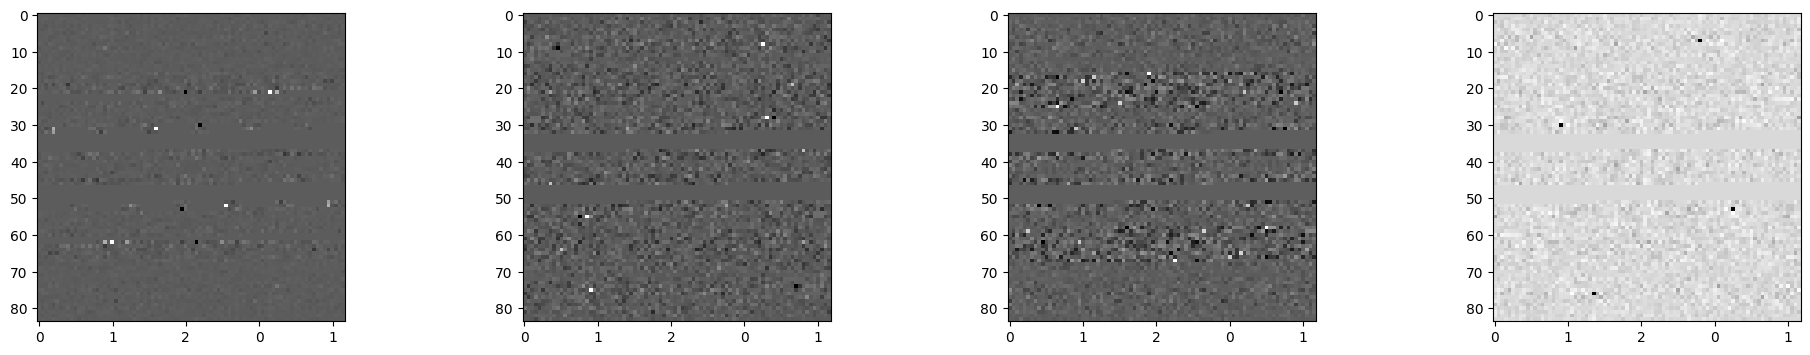

/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)


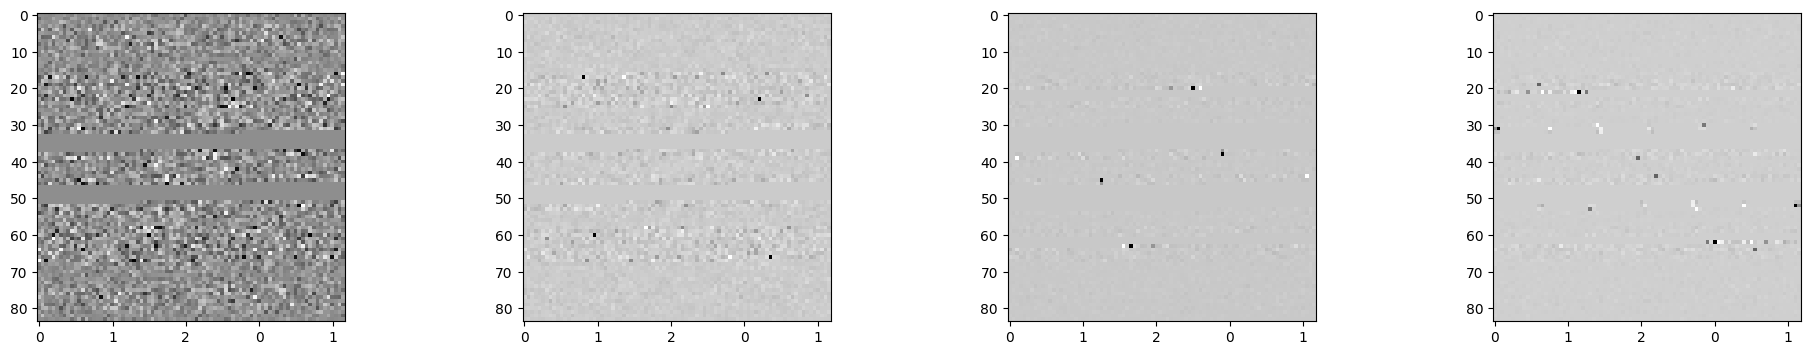

/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)


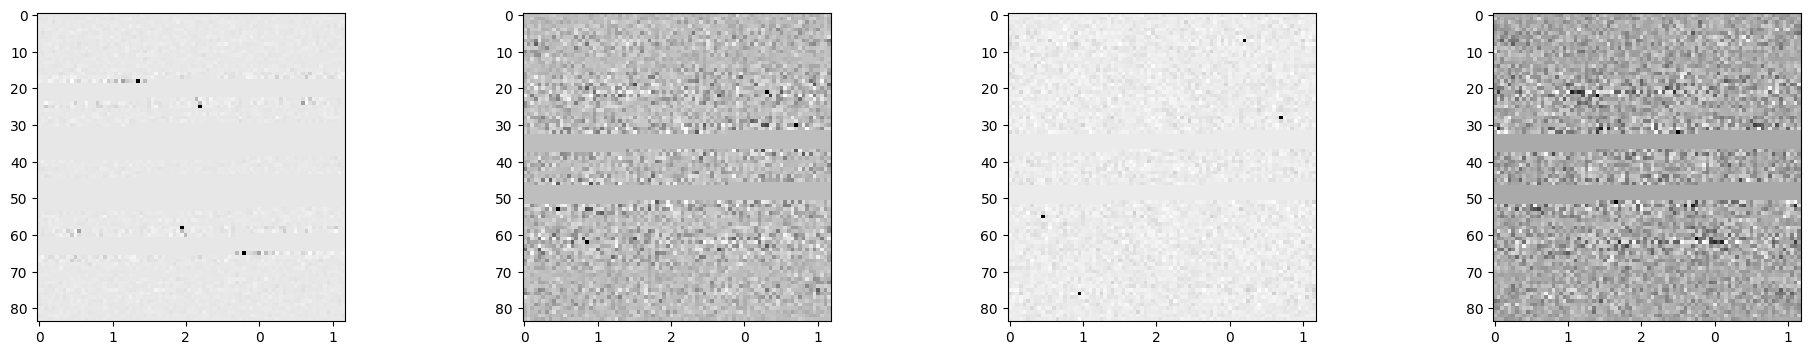

/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)
/tmp/ipykernel_902282/102047155.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)


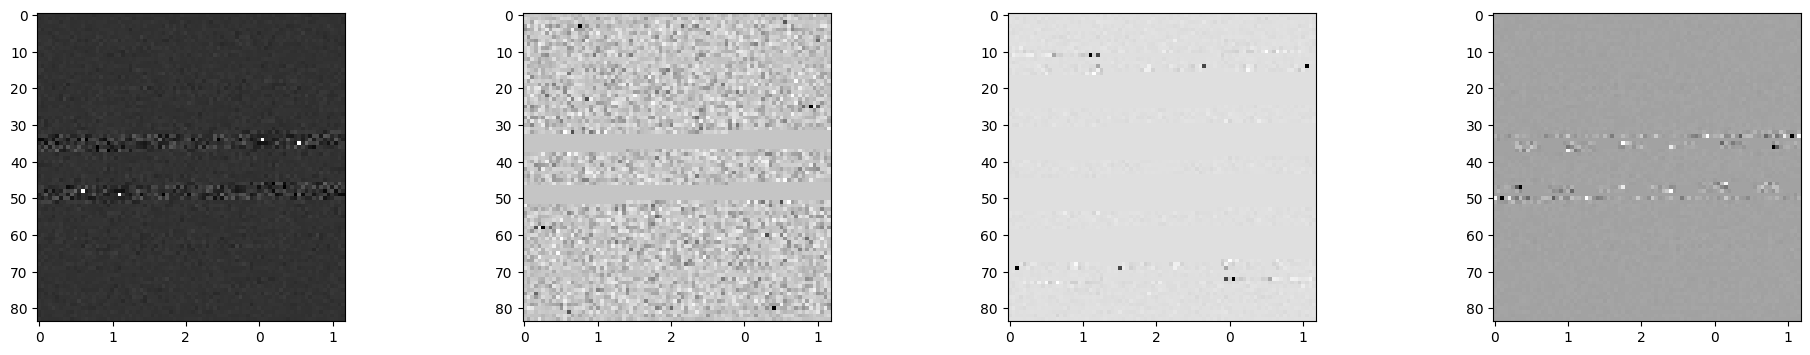

In [5]:
def showSubspace(subspace, Wshape, ndim=-1, channels=False):
    subspace = subspace.T

    if ndim == -1:
        ndim = subspace.shape[0]
    subspace = subspace[:ndim]

    ndim = subspace.shape[0]
    maxCols = min(ndim, 4)

    for j in range(ndim):
        if j % maxCols == 0:
            plt.show()
            nCols = maxCols if ndim - j > maxCols else ndim - j
            fig, axes = plt.subplots(1, nCols, figsize=(12 * nCols // 2, 9 // 2))
            try:
                axes[0]
            except:
                axes = [axes]

        kernel = subspace[j]
        kernel = kernel.reshape(*Wshape)

        if len(kernel.shape) == 3:
            kernel = kernel.transpose(1, 2, 0)
            if channels:
                kernel = np.concatenate([kernel[:, :, c] for c in range(kernel.shape[-1])], axis=1)
                axes[j%maxCols].add_patch(patches.Rectangle((-0.45, -0.45), 2.95, 2.95, facecolor='none', linestyle='--', linewidth=2, edgecolor='tab:red'))
                axes[j%maxCols].add_patch(patches.Rectangle((2.55, -0.45), 2.95, 2.95, facecolor='none', linestyle='--', linewidth=2, edgecolor='tab:green'))
                axes[j%maxCols].add_patch(patches.Rectangle((5.55, -0.45), 2.95, 2.95, facecolor='none', linestyle='--', linewidth=2, edgecolor='tab:blue'))

        axes[j%maxCols].imshow(kernel.round(decimals=6), cmap="Greys")
        axes[j%maxCols].set_xticklabels([0] + [0, 1, 2] * 3)

    plt.show()

transform_mat, eigenvectors, eigenvalues = get_equivariant_subspace(rotate_array, 14*14, 6*6)

print(f"The Reynolds operator tranformation matrix has dimension {transform_mat.shape}")
print(f"The subspace W is the subspace span by {eigenvectors.shape[1]} eigenvectors")
print("--- First 16 eigenvectors shown as images ---")
showSubspace(eigenvectors, (14*6, 14*6), ndim=16, channels=False)

### Standard Auto-Encoder

- **First, we will test the performance of a standard Auto-Encoder**
- The Original Train data contains regular MNIST images (shrink the resolution to $14\times 14$ to ease computation)
- The In-distribution Original Test data contains regular MNIST images
- The Out-of-distribution Rotated Test data contains rotated MNIST images (rotated at random)

In [6]:
# We first construct a standard Auto-Encoder
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # We will later replace the linear layers with a G-equivariant layers.
        # Rest of the code remains the same.
        self.encoder = nn.Sequential(
                nn.Linear(14*14, 36), # We fix the latent dimension
                nn.ELU(),
                nn.Linear(36, 9),
                nn.ELU()
            )

        self.decoder = nn.Sequential(
                nn.Linear(9, 36),
                nn.ELU(),
                nn.Linear(36, 14*14)
            )


    def forward(self, x):
        h = self.encoder(x)
        return self.decoder(h)


In [7]:
# We write our train and test functions here
def train_ae(train_loader, model, loss_fn, optimizer, epoch, device):

    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):

        # Reshaping the image to (-1, 14*14)
        data = data.reshape(-1, 14*14)
        data = data.to(device)

        optimizer.zero_grad()

        recon_batch = model(data) # reconstruct the dataset

        loss = loss_fn(recon_batch, data)

        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.6f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    
def test_ae(test_loader, model, loss_fn, device, rotation=False):
    torch.manual_seed(42)
    model.eval()
    test_loss = 0
    for batch_idx, (data, _) in enumerate(test_loader):
        
        if rotation:
            # we will randomly rotate the input to construct the rotated test dataset
            k = torch.randint(1, 4, (1,)).item() # randomly select a k for the rotation 90*k
            data = torch.rot90(data, k, [2, 3]) 
        # Reshaping the image to (-1, 14*14)
        data = data.reshape(-1, 14*14)
        data = data.to(device)


        recon_batch = model(data) # reconstruct the dataset

        loss = loss_fn(recon_batch, data)
        
        test_loss += loss.item()
    
    return test_loss/ len(test_loader.dataset)

We will then load the data and train the model.

In [ ]:
lr = 1e-3
from torch.utils.data import DataLoader

# set seed
torch.manual_seed(42)
np.random.seed(42)
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

# We will throw away the training labels during training

import torchvision.transforms as transforms

resize = transforms.Resize(size=(14, 14)) # We will shrink the size of the image for ease of computation
transform = transforms.Compose([resize, transforms.ToTensor()])

mnist_train = datasets.MNIST(root='../data_equi', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root='../data_equi', train=False, transform=transform, download=True)

kwargs = {'num_workers': 1, 'pin_memory': True} 
train_loader = DataLoader(dataset=mnist_train, batch_size=128, shuffle=True, **kwargs)
test_loader = DataLoader(dataset=mnist_test, batch_size=128, shuffle=True, **kwargs)

ae = AutoEncoder().to(device)

ae_optimizer = optim.Adam(ae.parameters(), lr=lr)
ae_loss_fn = torch.nn.MSELoss() # We use MSE loss for Auto-Encoder reconstruction

for epoch in range(1, 20):
    train_ae(train_loader, ae, ae_loss_fn, ae_optimizer, epoch, device)

100%|██████████| 9.91M/9.91M [00:00<00:00, 57.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.45MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 13.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 3.34MB/s]
/home/shams3/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


In [ ]:
test_loss = test_ae(test_loader, ae, ae_loss_fn, device)
test_rotat_loss = test_ae(test_loader, ae, ae_loss_fn, device, rotation=True)
print("For a standard Auto-Encoder model")
print("In-distribution Test Loss", "{:.6f}".format(test_loss))
print("Out-of-distribution (Rotated)  Test Loss", "{:.6f}".format(test_rotat_loss))

We can observe the difference in loss for *in-distribution* and *out-of-distribution* test data.

### G-Equivariant Auto-Encoder

- **First, we will test the performance of a G-equivariant Auto-Encoder**
- The original training data contains (mostly) upright MNIST images (we scale the images to $14\times 14$ to simplify the computation)
- The **in-distribution test** data contains regular **test** MNIST images
- The **out-of-distribution test** data contains rotated MNIST images (rotated at random)

In the following, we define the GEquivariantLayer() and GEquivariantAutoEncoder() class. 

**Note that there are missing parts in the code for you to fill (marked with TODO).**

In [ ]:
class GEquivariantLayer(nn.Module):
    
    def __init__(self, input_dim, output_dim):
        super().__init__()
        
        self.input_dim = input_dim 
        self.output_dim = output_dim
        # Load the left 1-eigenvectors of the Reynolds operator that we computed before.
        _, eigenvectors, _ = get_equivariant_subspace(rotate_array, self.input_dim, self.output_dim)
        eigentensor = torch.from_numpy(eigenvectors).float()
        self.basis = eigentensor.T
        
        self.coeffs = nn.Parameter(torch.Tensor(self.basis.shape[0], 1))
        # TODO: Fill the parameter dimension of the bias term


        _, bias_eigenvectors, _ = get_equivariant_subspace(rotate_array, self.output_dim, self.output_dim)
        bias_eigentensor = torch.from_numpy(bias_eigenvectors).float()
        self.bias_basis = bias_eigentensor.T

        self.bias = nn.Parameter(torch.Tensor(self.bias_basis.shape[0], 1))
        # WARNING: Careful with the bias so it does not break the equivariance.
        
        stdv = 1.0/np.sqrt(output_dim)
        self.coeffs.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()
    

    def forward(self, X):
        # Input shape: torch.Size([minibatch, input_dim])
        
        if self.basis.device != X.device:
            self.basis = self.basis.to(X.device)

        # Construct weight w \in \mathcal{W} (the left 1-eigenspace)
        #      using the current learnable coefficients.
        # coeffs: (output_dim, n_basis, 1)
        # basis  : (n_basis, input_dim)
        # result after torch.mul : (output_dim, n_basis, input_dim)
        # result after sum : (output_dim, input_dim)
        # TODO: Fill in how we can construct the weights by the basis eigenvectors

        
        weights = torch.mul(self.coeffs, self.basis)
        weights = weights.sum(dim=-2)
        weights = weights.view(self.output_dim, self.input_dim)

        # Output shape: torch.Size([minibatch, output_dim])
        out = X @ weights.T + self.bias

        return out

In [ ]:
class GEquivariantAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Replace the every layer with a G-equivariant layer.
        self.first_layer = GEquivariantLayer(14*14, 6*6)
        self.second_layer = GEquivariantLayer(6*6, 3*3)
        self.third_layer = GEquivariantLayer(3*3, 6*6)
        self.fourth_layer = GEquivariantLayer(6*6, 14*14)
        
        self.encoder = nn.Sequential(
                self.first_layer,
                nn.ELU(),
                self.second_layer,
                nn.ELU()
        )
        
        self.decoder = nn.Sequential(
                self.third_layer,
                nn.ELU(),
                self.fourth_layer,
        )
                
    def forward(self, x):
        h = self.encoder(x)
        return self.decoder(h)

In [ ]:
G_eq_ae = GEquivariantAutoEncoder()
ae_optimizer = optim.Adam(G_eq_ae.parameters(), lr=lr)
ae_loss_fn = torch.nn.MSELoss()

for epoch in range(1, 20):
    train_ae(train_loader, G_eq_ae, ae_loss_fn, ae_optimizer, epoch, device)


In [ ]:
test_loss = test_ae(test_loader, G_eq_ae, ae_loss_fn, device)
test_rotat_loss = test_ae(test_loader, G_eq_ae, ae_loss_fn, device, rotation=True)
print("For a G-equivariant Auto-Encoder")
print("In-distribution Test Loss", "{:.6f}".format(test_loss))
print("Out-of-distribution (Rotated) Test Loss", "{:.6f}".format(test_rotat_loss))

We can see the OOD performance is the same as the in-distribution performance. An example can be visualized as such:
<center><img src="example-G-equi-ae-output.png" width=700px /></center>

In [ ]:
# Create a figure with 2 rows and 3 columns of subplots
fig, axs = plt.subplots(nrows=2, ncols=3)

ae = ae.to('cpu')
G_eq_ae = G_eq_ae.to('cpu')

x_example = mnist_test[9][0] # you can use a different example here
rot_x_example = torch.rot90(mnist_test[9][0], 3, [1, 2]) # rotate 270 degree

fig.subplots_adjust(hspace=0.4)

axs[0, 0].imshow(x_example.squeeze().numpy())
axs[0, 0].set_title("Input")
axs[0, 1].imshow(ae(x_example.reshape(1,-1)).detach().numpy().reshape(14,14))
axs[0, 1].set_title("AE Output")
axs[0, 2].imshow(G_eq_ae(x_example.reshape(1,-1)).detach().numpy().reshape(14,14))
axs[0, 2].set_title("G-Equivariant AE Output")
axs[1, 0].set_title("Rotated Input")
axs[1, 0].imshow(rot_x_example.squeeze().numpy())
axs[1, 1].set_title("AE Output")
axs[1, 1].imshow(ae(rot_x_example.reshape(1,-1)).detach().numpy().reshape(14,14))
axs[1, 2].set_title("G-Equivariant AE Output")
axs[1, 2].imshow(G_eq_ae(rot_x_example.reshape(1,-1)).detach().numpy().reshape(14,14))

# Save figure
plt.savefig('comparison.png')

# Show the plot
plt.show()

---

## Part 2: G-Invariant Attention Pooling

Now we extend the G-equivariant autoencoder by adding **G-invariant attention pooling** to create a global embedding. This architecture combines:

- **Local G-equivariant features** $\mathbf{h}$: Features that transform predictably under group actions
- **Global G-invariant embedding** $\mathbf{g}$: A pooled representation that remains unchanged under group actions

### Key Insight: Attention as Reynolds Operator

The attention mechanism can be made G-invariant by computing attention over group orbits. Given G-equivariant features $\mathbf{h} \in \mathbb{R}^k$, we compute:

$$\alpha_i = \frac{\exp(\mathbf{q}^T \rho(g_i) \mathbf{h})}{\sum_{j=1}^{|G|} \exp(\mathbf{q}^T \rho(g_j) \mathbf{h})} \quad \text{for each } g_i \in G$$

$$\mathbf{g} = \sum_{i=1}^{|G|} \alpha_i \cdot \rho(g_i) \mathbf{h}$$

where $\mathbf{q} \in \mathbb{R}^k$ is a **learnable query vector**.

**Why is this G-invariant?** When we transform the input $\mathbf{h} \to \rho(g')\mathbf{h}$, the set of orbit samples $\{\rho(g_i)\mathbf{h}\}$ just gets permuted (due to group closure), so the weighted sum remains the same.

### Step 1: Get Group Representation Matrices

First, we need to obtain the group representation matrices $\rho(g)$ for the feature space. These matrices describe how each group element transforms the features.

In [ ]:
def get_group_representations(feature_dim):
    """
    Get the group representation matrices rho(g) for the rotation group G.
    
    Args:
        feature_dim: The dimension of the feature space (must be a perfect square, e.g., 36 = 6x6)
    
    Returns:
        group_reps: List of torch tensors [rho(0°), rho(90°), rho(180°), rho(270°)]
                    Each tensor has shape (feature_dim, feature_dim)
    """
    n = int(np.sqrt(feature_dim))
    assert n * n == feature_dim, "feature_dim must be a perfect square"
    
    group_reps = []
    for degree in [0, 90, 180, 270]:
        # Compute the representation matrix by applying rotation to one-hot vectors
        pool = mp.Pool(NUM_TRANSFORM_CPUS)
        rep_mat = pool.map(
            partial(
                transformed_onehot_degree,
                transform_func=rotate_array, shape=(n, n), degree=degree,
            ),
            range(feature_dim),
        )
        pool.close()
        pool.join()
        rep_mat = np.stack(rep_mat, axis=1)  # Shape: (feature_dim, feature_dim)
        group_reps.append(torch.from_numpy(rep_mat).float())
    
    return group_reps

# Test: Get group representations for 6x6 = 36 dimensional features
group_reps_36 = get_group_representations(36)
print(f"Number of group elements: {len(group_reps_36)}")
print(f"Shape of each representation matrix: {group_reps_36[0].shape}")

### Step 2: Implement G-Invariant Attention Pooling

**TODO: Fill in the missing code to implement G-invariant attention pooling.**

The module should:
1. Transform the input features by each group element: $\rho(g_i) \mathbf{h}$ for all $g_i \in G$
2. Compute attention scores using a learnable query: $s_i = \mathbf{q}^T \rho(g_i) \mathbf{h}$
3. Apply softmax to get attention weights: $\alpha_i = \text{softmax}(s_i)$
4. Compute weighted sum: $\mathbf{g} = \sum_i \alpha_i \cdot \rho(g_i) \mathbf{h}$

In [ ]:
class GInvariantAttentionPool(nn.Module):
    """
    G-Invariant Attention Pooling Module.
    
    Given G-equivariant features h, computes a G-invariant global embedding g
    by attending over the group orbit {rho(g_i) * h : g_i in G}.
    """
    
    def __init__(self, feature_dim, group_reps):
        """
        Args:
            feature_dim: Dimension of input features (must be perfect square)
            group_reps: List of group representation matrices [rho(g) for g in G]
                        Each matrix has shape (feature_dim, feature_dim)
        """
        super().__init__()
        
        self.feature_dim = feature_dim
        self.num_group_elements = len(group_reps)
        
        # Store group representations as a buffer (not a parameter)
        # Stack into tensor of shape (|G|, feature_dim, feature_dim)
        self.register_buffer('group_reps', torch.stack(group_reps, dim=0))
        
        # TODO: Initialize the learnable query vector
        self.query = nn.Parameter(torch.Tensor(self.feature_dim,1))
        
        # Initialize query with small random values
        nn.init.normal_(self.query, mean=0, std=0.01)
    
    def forward(self, h):
        """
        Compute G-invariant global embedding via attention over group orbits.
        
        Args:
            h: G-equivariant features of shape (batch_size, feature_dim)
        
        Returns:
            g: G-invariant global embedding of shape (batch_size, feature_dim)
            attention_weights: Attention weights of shape (batch_size, |G|) - for visualization
        """
        batch_size = h.shape[0]
        
        # Step 1: Compute orbit samples rho(g_i) @ h for each g_i in G
        # h has shape (batch, feature_dim)
        # group_reps has shape (|G|, feature_dim, feature_dim)
        # We want orbit_samples of shape (batch, |G|, feature_dim)
        
        # TODO: Compute orbit samples
        orbit_samples = self.group_reps @ h 
        
        # Step 2: Compute attention scores using query
        # TODO: Compute attention scores
        scores = self.query.T @ orbit_samples 

        # Step 3: Apply softmax to get attention weights
        # TODO: Compute attention weights using softmax over the group dimension
        attention_weights = nn.functional.softmax(scores, dim=0)
        
        # Step 4: Compute weighted sum to get G-invariant embedding
        # TODO: Compute the weighted sum
        g = (attention_weights * orbit_samples).sum(dim=0)
        
        return g, attention_weights

### Important: Constrained Combine Layer for End-to-End Equivariance

When combining G-equivariant features $\mathbf{h}$ with G-invariant features $\mathbf{g}$, the weight matrix must be properly constrained:

$$W = [W_h \mid W_g] \in \mathbb{R}^{k \times 2k}$$

**Constraints:**
1. $W_h$: Must satisfy $\rho(g) W_h = W_h \rho(g)$ (standard G-equivariance)
2. $W_g$: Columns must be in the **invariant subspace** of $\rho$, i.e., $\rho(g) W_g = W_g$
3. Bias $\mathbf{b}$: Must also be in the invariant subspace

**Key insight:** $W_g$ maps the invariant input $\mathbf{g}$ into an equivariant output. But the only way to do this equivariantly is if the output is also invariant. So columns of $W_g$ must be fixed points under $\rho(g)$.

In [ ]:
def get_invariant_subspace_basis(feature_dim):
    """
    Compute orthonormal basis for the G-invariant subspace.
    These are vectors v such that rho(g) @ v = v for all g in G.
    """
    n = int(np.sqrt(feature_dim))
    assert n * n == feature_dim
    
    # Get rotation representations
    group_reps = []
    for degree in [0, 90, 180, 270]:
        pool = mp.Pool(NUM_TRANSFORM_CPUS)
        rep_mat = pool.map(
            partial(transformed_onehot_degree, transform_func=rotate_array, shape=(n, n), degree=degree),
            range(feature_dim),
        )
        pool.close()
        pool.join()
        group_reps.append(np.stack(rep_mat, axis=1))
    
    # Reynolds operator: T_bar = (1/|G|) * sum_g rho(g)
    T_bar = sum(group_reps) / len(group_reps)
    
    # SVD to get basis for image of T_bar (= invariant subspace)
    U, S, Vh = np.linalg.svd(T_bar)
    rank = np.sum(S > 1e-10)
    
    return torch.from_numpy(U[:, :rank]).float(), rank


class GEquivariantCombineLayer(nn.Module):
    """
    G-Equivariant layer for combining [h || g] where h is equivariant and g is invariant.
    
    Properly constrains:
    - W_h to the equivariant subspace (intertwiner)
    - W_g columns to the invariant subspace
    - bias to the invariant subspace
    """
    
    def __init__(self, equivariant_dim, invariant_dim, output_dim):
        super().__init__()
        
        assert equivariant_dim == invariant_dim == output_dim, "For simplicity, all dims must be equal"
        self.dim = output_dim
        
        # Get equivariant subspace for W_h (same as GEquivariantLayer)
        _, equiv_eigenvectors, _ = get_equivariant_subspace(rotate_array, self.dim, self.dim)
        self.equiv_basis = torch.from_numpy(equiv_eigenvectors).float().T  # Shape: (n_basis, dim*dim)
        
        # Get invariant subspace for W_g columns and bias
        self.inv_basis, self.inv_rank = get_invariant_subspace_basis(self.dim)  # Shape: (dim, inv_rank)
        
        # Learnable coefficients
        # W_h: parameterized by equivariant basis
        self.coeffs_h = nn.Parameter(torch.Tensor(self.equiv_basis.shape[0], 1))
        
        # W_g: columns in invariant subspace, so W_g = inv_basis @ C
        # C has shape (inv_rank, dim) -> W_g has shape (dim, dim)
        self.coeffs_g = nn.Parameter(torch.Tensor(self.inv_rank, self.dim))
        
        # Bias: in invariant subspace, so bias = inv_basis @ b_coeffs
        self.bias_coeffs = nn.Parameter(torch.Tensor(self.inv_rank))
        
        # Initialize
        stdv = 1.0 / np.sqrt(output_dim)
        self.coeffs_h.data.uniform_(-stdv, stdv)
        self.coeffs_g.data.uniform_(-stdv, stdv)
        self.bias_coeffs.data.zero_()
    
    def forward(self, h, g):
        """
        Args:
            h: G-equivariant features (batch, dim)
            g: G-invariant features (batch, dim)
        Returns:
            y: G-equivariant output (batch, dim)
        """
        # Move bases to correct device
        if self.equiv_basis.device != h.device:
            self.equiv_basis = self.equiv_basis.to(h.device)
        if self.inv_basis.device != h.device:
            self.inv_basis = self.inv_basis.to(h.device)
        
        # Construct W_h from equivariant basis
        W_h = (self.coeffs_h * self.equiv_basis).sum(dim=0).view(self.dim, self.dim)
        
        # Construct W_g: columns in invariant subspace
        # W_g = inv_basis @ coeffs_g, shape: (dim, inv_rank) @ (inv_rank, dim) = (dim, dim)
        W_g = self.inv_basis @ self.coeffs_g
        
        # Construct bias in invariant subspace
        bias = self.inv_basis @ self.bias_coeffs  # (dim,)
        
        # Compute output: y = W_h @ h + W_g @ g + bias
        y = h @ W_h.T + g @ W_g.T + bias
        
        return y


# Test the layer
print("Testing GEquivariantCombineLayer...")
combine_layer = GEquivariantCombineLayer(9, 9, 9)
h_test = torch.randn(2, 9)
g_test = torch.randn(2, 9)
y_test = combine_layer(h_test, g_test)
print(f"Input h shape: {h_test.shape}, g shape: {g_test.shape}")
print(f"Output shape: {y_test.shape}")
print(f"Number of parameters: {sum(p.numel() for p in combine_layer.parameters())}")
print("Layer created successfully!")

### Step 3: Build the G-Equivariant Autoencoder with Attention Pooling

Now we combine:
1. **G-equivariant encoder layers** → produces local features $\mathbf{h}$
2. **G-invariant attention pooling** → produces global embedding $\mathbf{g}$
3. **Combination MLP** → combines $[\mathbf{h} \| \mathbf{g}]$ 
4. **G-equivariant decoder layers** → reconstructs the output

**Note:** The concatenation $[\mathbf{h} \| \mathbf{g}]$ has a specific transformation behavior:
- Under group action $g$: $[\rho(g)\mathbf{h} \| \mathbf{g}]$ (local transforms, global stays fixed)
- This is a block-diagonal transformation!

In [ ]:
class GEquivariantAttentionAE(nn.Module):
    """
    G-Equivariant Autoencoder with G-Invariant Attention Pooling.
    
    Architecture:
    - Encoder: G-equivariant layers producing local features h
    - Attention Pool: Produces G-invariant global embedding g
    - Combine Layer: Properly constrained to maintain equivariance
    - Decoder: G-equivariant layers for reconstruction
    """
    
    def __init__(self):
        super().__init__()
        
        # G-equivariant encoder (same as before)
        self.encoder_layer1 = GEquivariantLayer(14*14, 6*6)  # 196 -> 36
        self.encoder_layer2 = GEquivariantLayer(6*6, 3*3)     # 36 -> 9
        
        # Get group representations for the bottleneck dimension (3x3 = 9)
        group_reps_9 = get_group_representations(9)
        
        # G-invariant attention pooling on bottleneck features
        self.attention_pool = GInvariantAttentionPool(9, group_reps_9)
        
        # Properly constrained combine layer (replaces unconstrained MLP)
        # This ensures end-to-end G-equivariance!
        self.combine_layer = GEquivariantCombineLayer(9, 9, 9)
        
        # G-equivariant decoder (same as before)
        self.decoder_layer1 = GEquivariantLayer(3*3, 6*6)    # 9 -> 36
        self.decoder_layer2 = GEquivariantLayer(6*6, 14*14)  # 36 -> 196
        
        self.activation = nn.ELU()
    
    def encode(self, x):
        """
        Encode input to local G-equivariant features.
        
        Returns:
            h: Local G-equivariant features (batch, 9)
        """
        h = self.activation(self.encoder_layer1(x))
        h = self.activation(self.encoder_layer2(h))
        return h
    
    def forward(self, x):
        """
        Full forward pass with attention pooling.
        
        Returns:
            recon: Reconstructed output
            attention_weights: Attention weights for visualization
        """
        # Encode to get local G-equivariant features
        h = self.encode(x)  # (batch, 9)
        
        # Get G-invariant global embedding via attention pooling
        g, attention_weights = self.attention_pool(h)  # g: (batch, 9)
        
        # Combine using properly constrained layer
        z = self.activation(self.combine_layer(h, g))  # (batch, 9)
        
        # Decode
        recon = self.activation(self.decoder_layer1(z))
        recon = self.decoder_layer2(recon)
        
        return recon, attention_weights
    
    def forward_no_attention(self, x):
        """Forward pass returning only reconstruction (for compatibility with train/test functions)."""
        recon, _ = self.forward(x)
        return recon

### Step 4: Train and Evaluate the Attention-Augmented Model

Train the G-equivariant autoencoder with attention pooling and compare it to the standard G-equivariant autoencoder from Part 1.

In [ ]:
# Modified training function for attention model (handles tuple output)
def train_ae_attention(train_loader, model, loss_fn, optimizer, epoch, device):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.reshape(-1, 14*14)
        data = data.to(device)

        optimizer.zero_grad()
        
        # Use forward_no_attention for training (ignores attention weights)
        recon_batch = model.forward_no_attention(data)
        
        loss = loss_fn(recon_batch, data)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print('====> Epoch: {} Average loss: {:.6f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

def test_ae_attention(test_loader, model, loss_fn, device, rotation=False):
    torch.manual_seed(42)
    model.eval()
    test_loss = 0
    for batch_idx, (data, _) in enumerate(test_loader):
        if rotation:
            k = torch.randint(1, 4, (1,)).item()
            data = torch.rot90(data, k, [2, 3]) 
        data = data.reshape(-1, 14*14)
        data = data.to(device)

        recon_batch = model.forward_no_attention(data)
        loss = loss_fn(recon_batch, data)
        test_loss += loss.item()
    
    return test_loss / len(test_loader.dataset)

In [ ]:
# Train the G-Equivariant Autoencoder with Attention Pooling
# NOTE: This cell will only work after you complete the TODOs above!

G_eq_attn_ae = GEquivariantAttentionAE().to(device)
attn_optimizer = optim.Adam(G_eq_attn_ae.parameters(), lr=lr)
attn_loss_fn = torch.nn.MSELoss()

print("Training G-Equivariant AE with Attention Pooling...")
for epoch in range(1, 20):
    train_ae_attention(train_loader, G_eq_attn_ae, attn_loss_fn, attn_optimizer, epoch, device)

In [ ]:
# Compare all three models
print("=" * 60)
print("COMPARISON OF ALL MODELS")
print("=" * 60)

# Standard AE (from Part 1)
ae_test = test_ae(test_loader, ae, ae_loss_fn, device)
ae_rot_test = test_ae(test_loader, ae, ae_loss_fn, device, rotation=True)
print(f"\nStandard Auto-Encoder:")
print(f"  In-distribution Test Loss:  {ae_test:.6f}")
print(f"  OOD (Rotated) Test Loss:    {ae_rot_test:.6f}")

# G-Equivariant AE (from Part 1)
geq_test = test_ae(test_loader, G_eq_ae, ae_loss_fn, device)
geq_rot_test = test_ae(test_loader, G_eq_ae, ae_loss_fn, device, rotation=True)
print(f"\nG-Equivariant Auto-Encoder:")
print(f"  In-distribution Test Loss:  {geq_test:.6f}")
print(f"  OOD (Rotated) Test Loss:    {geq_rot_test:.6f}")

# G-Equivariant AE with Attention (Part 2)
geq_attn_test = test_ae_attention(test_loader, G_eq_attn_ae, attn_loss_fn, device)
geq_attn_rot_test = test_ae_attention(test_loader, G_eq_attn_ae, attn_loss_fn, device, rotation=True)
print(f"\nG-Equivariant AE with Attention Pooling:")
print(f"  In-distribution Test Loss:  {geq_attn_test:.6f}")
print(f"  OOD (Rotated) Test Loss:    {geq_attn_rot_test:.6f}")
print("=" * 60)

### Step 5: Visualize Attention Weights

Visualize the learned attention weights $\alpha_i$ for several test images. 

**Questions to consider:**
- Are the weights uniform across group elements (0°, 90°, 180°, 270°)?
- Do the weights vary depending on the input image?
- What does this tell you about what the attention mechanism has learned?

In [ ]:
def visualize_attention_weights(model, test_data, num_samples=8, device='cpu'):
    """
    Visualize attention weights for several test images.
    
    Args:
        model: Trained GEquivariantAttentionAE model
        test_data: Test dataset
        num_samples: Number of samples to visualize
        device: Device to use
    """
    model.eval()
    model = model.to(device)
    
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 3*num_samples))
    
    group_labels = ['0°', '90°', '180°', '270°']
    
    for i in range(num_samples):
        # Get a test image
        img, label = test_data[i]
        x = img.reshape(1, -1).to(device)
        
        # Get reconstruction and attention weights
        with torch.no_grad():
            recon, attn_weights = model(x)
        
        # Plot original image
        axes[i, 0].imshow(img.squeeze().numpy(), cmap='gray')
        axes[i, 0].set_title(f'Input (digit {label})')
        axes[i, 0].axis('off')
        
        # Plot reconstruction
        axes[i, 1].imshow(recon.cpu().numpy().reshape(14, 14), cmap='gray')
        axes[i, 1].set_title('Reconstruction')
        axes[i, 1].axis('off')
        
        # Plot attention weights as bar chart
        weights = attn_weights.cpu().numpy().flatten()
        bars = axes[i, 2].bar(group_labels, weights, color=['blue', 'orange', 'green', 'red'])
        axes[i, 2].set_ylim(0, 1)
        axes[i, 2].set_title('Attention Weights')
        axes[i, 2].set_ylabel('Weight')
        
        # Add weight values on bars
        for bar, w in zip(bars, weights):
            axes[i, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02, 
                          f'{w:.3f}', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('attention_weights_visualization.png', dpi=150)
    plt.show()
    
    return

# Visualize attention weights for test images
print("Visualizing attention weights...")
visualize_attention_weights(G_eq_attn_ae, mnist_test, num_samples=8, device=device)

### Step 6: Compare Reconstructions (In-distribution vs OOD)

Compare reconstructions of all three models on both upright and rotated inputs.

In [ ]:
# Final comparison: All models on upright and rotated inputs
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))

# Move models to CPU for visualization
ae_cpu = ae.to('cpu')
G_eq_ae_cpu = G_eq_ae.to('cpu')
G_eq_attn_ae_cpu = G_eq_attn_ae.to('cpu')

# Get example image
example_idx = 9  # Change this to try different images
x_example = mnist_test[example_idx][0]
rot_x_example = torch.rot90(x_example, 3, [1, 2])  # 270 degree rotation

fig.subplots_adjust(hspace=0.4, wspace=0.3)

# Row 1: Upright input
axs[0, 0].imshow(x_example.squeeze().numpy(), cmap='gray')
axs[0, 0].set_title("Input (Upright)")
axs[0, 0].axis('off')

axs[0, 1].imshow(ae_cpu(x_example.reshape(1,-1)).detach().numpy().reshape(14,14), cmap='gray')
axs[0, 1].set_title("Standard AE")
axs[0, 1].axis('off')

axs[0, 2].imshow(G_eq_ae_cpu(x_example.reshape(1,-1)).detach().numpy().reshape(14,14), cmap='gray')
axs[0, 2].set_title("G-Equivariant AE")
axs[0, 2].axis('off')

recon_attn, _ = G_eq_attn_ae_cpu(x_example.reshape(1,-1))
axs[0, 3].imshow(recon_attn.detach().numpy().reshape(14,14), cmap='gray')
axs[0, 3].set_title("G-Equiv AE + Attention")
axs[0, 3].axis('off')

# Row 2: Rotated input (OOD)
axs[1, 0].imshow(rot_x_example.squeeze().numpy(), cmap='gray')
axs[1, 0].set_title("Input (Rotated 270°)")
axs[1, 0].axis('off')

axs[1, 1].imshow(ae_cpu(rot_x_example.reshape(1,-1)).detach().numpy().reshape(14,14), cmap='gray')
axs[1, 1].set_title("Standard AE")
axs[1, 1].axis('off')

axs[1, 2].imshow(G_eq_ae_cpu(rot_x_example.reshape(1,-1)).detach().numpy().reshape(14,14), cmap='gray')
axs[1, 2].set_title("G-Equivariant AE")
axs[1, 2].axis('off')

recon_rot_attn, _ = G_eq_attn_ae_cpu(rot_x_example.reshape(1,-1))
axs[1, 3].imshow(recon_rot_attn.detach().numpy().reshape(14,14), cmap='gray')
axs[1, 3].set_title("G-Equiv AE + Attention")
axs[1, 3].axis('off')

plt.suptitle("Comparison: Standard AE vs G-Equivariant AE vs G-Equiv AE with Attention", fontsize=14)
plt.savefig('final_comparison.png', dpi=150, bbox_inches='tight')
plt.show()